In [1]:
regenerate = False

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
import numpy as np

import camb
from camb import model, initialpower
import pandas as pd

In [3]:
from cassL import camb_interface as ci

In [4]:
# Please refer to the notebook "what_is_truth"
# for a detailed review of this parameter.
asymptote_sample_size = 10

omega_index = 3 # while we debug, we confine our attention to just one value
onh2 = ci.OMNUH2_FLOATS[omega_index]
onh2_str = ci.OMNUH2_STRS[omega_index]
snap_index = 0

skips_omega = np.delete(ci.OMNUH2_FLOATS, omega_index)
skips_snaps = np.delete(ci.ALETHEIA_SNAPS, snap_index)

In [5]:
model0 = ci.specify_neutrino_mass(ci.cosm.iloc[0], onh2)

In [7]:
'''
First, we need to define a Pandas table containing my exotic cosmologies.
'''
num_degenerate = 100 # how many models are we testing
random_cosm = None

if regenerate == True:
    def row_conglomerator():
        rows = [ci.get_As_matched_random_cosmology(onh2) for i in range(num_degenerate)]
        rows.insert(0, model0)
        conglomerate = {}
        for key in rows[0].keys():
            conglomerate[key] = [rows[0][key]]
            for i in range(1, num_degenerate + 1):
                conglomerate[key].append(rows[i][key])
        return conglomerate

    conglomerate = row_conglomerator()
    random_cosm = pd.DataFrame.from_dict(conglomerate)
    # We need to write this dataframe as a CSV. Trying to retrieve it from
    # numpy seems obscure.
    random_cosm.to_csv("degenerate_cosmologies.csv")
else:
    random_cosm = pd.read_csv("degenerate_cosmologies.csv")

In [8]:
m0_only = pd.Series(model0).to_frame().T
m0_only

,Name,ombh2,omch2,n_s,A_s,OmB,OmC,OmM,OmK,OmL,...,z(4),z(3),z(2),z(1),z(0),Lbox,sigma8,omnuh2,mnu,nnu_massive
0,Columbus_0,0.022445,0.120567,0.96,0.0,0.05,0.268584,0.318584,0.0,0.681416,...,2.0,1.0,0.57,0.3,0.0,1000.0,0.82755,0.01,0.930425,1


In [9]:
# It's a waste of time to consider all of the omegas and snapshots, so we're
# making heavy use of skips.
if regenerate:
    spec_sim = ci.boltzmann_battery(ci.OMNUH2_FLOATS,
        skips_omega = skips_omega, skips_model=list(range(1, 9)), \
        skips_snapshot=skips_snaps)
    np.save("As_degenerate_spectra.npy", spec_sim, allow_pickle=True)
else:
    spec_sim = np.load("As_degenerate_spectra.npy", allow_pickle=True)

In [10]:
target, redshifts = None, None

if regenerate:
    # The target should always be selected at snapshot
    # 0, i.e. z=2
    target = spec_sim[onh2][0][0]['s12_massless'][0]

    # We'll evaluate each cosmology at the corresponding
    # redshift entry here, to keep things even.
    redshifts = [2] # this is the redshift which in model 0 is associated with the
    # sigma12 value we're using
    for i in range(1, num_degenerate + 1):
        print(i  % 10, end='')
        z = ci.match_sigma12(target, 0.001, random_cosm.loc[i])
        redshifts.append(z)

    np.save("degenerate_redshifts.npy", redshifts, allow_pickle=True)
else:
    redshifts = np.load("degenerate_redshifts.npy", allow_pickle=True)

1234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890

In [11]:
spec_sim[onh2][0][0]['s12_massless'][0]

0.34330936892866387

In [12]:
# This is a disgusting hack, but it's quite succinct
def decoy_parser(mindex):
    return [redshifts[mindex]]

ci.parse_redshifts = decoy_parser

spec_sims = None
if regenerate:
    spec_sims = ci.boltzmann_battery(ci.OMNUH2_FLOATS,
        skips_omega = skips_omega, skips_model=[], skips_snapshot=skips_snaps,
        models=random_cosm)

    np.save("degenerate_spectra.npy", spec_sims, allow_pickle=True)
else:
    spec_sims = np.load("degenerate_spectra.npy", allow_pickle=True).item()

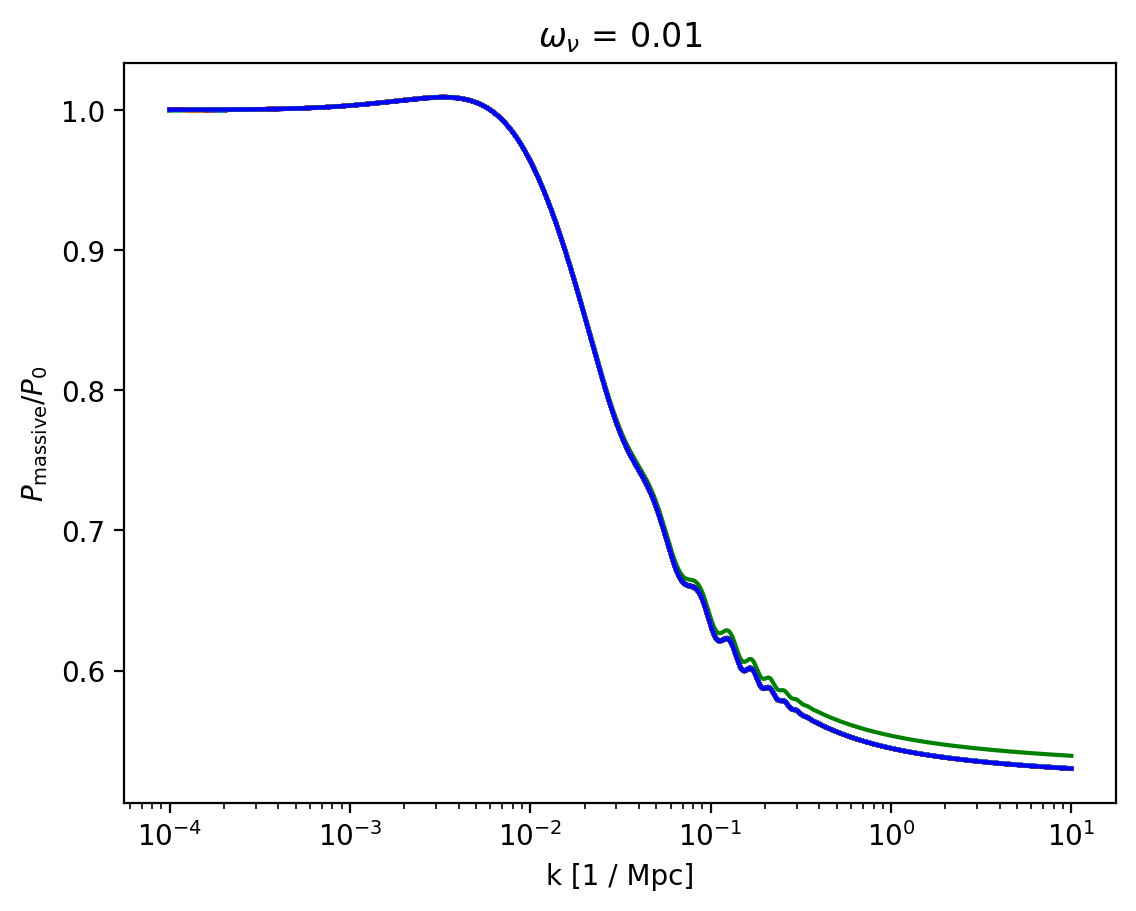

In [13]:
colors = ci.colors * 200
styles = ci.styles * 200
for i in range(len(spec_sims[onh2])):
    if spec_sims[onh2][i] is None:
        continue
    h = random_cosm.loc[i]["h"]
    for j in range(len(spec_sims[onh2][i])):
        sim = spec_sims[onh2][i][j]
        
        if sim is None:
            continue
        plt.plot(sim["k"],
            sim["P_nu"] / sim["P_no"],
            label="model " + str(i) + ", z=" + str(sim["z"]), c=colors[i],
            linestyle=styles[i])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.title(r"$\omega_\nu$ = " + onh2_str)

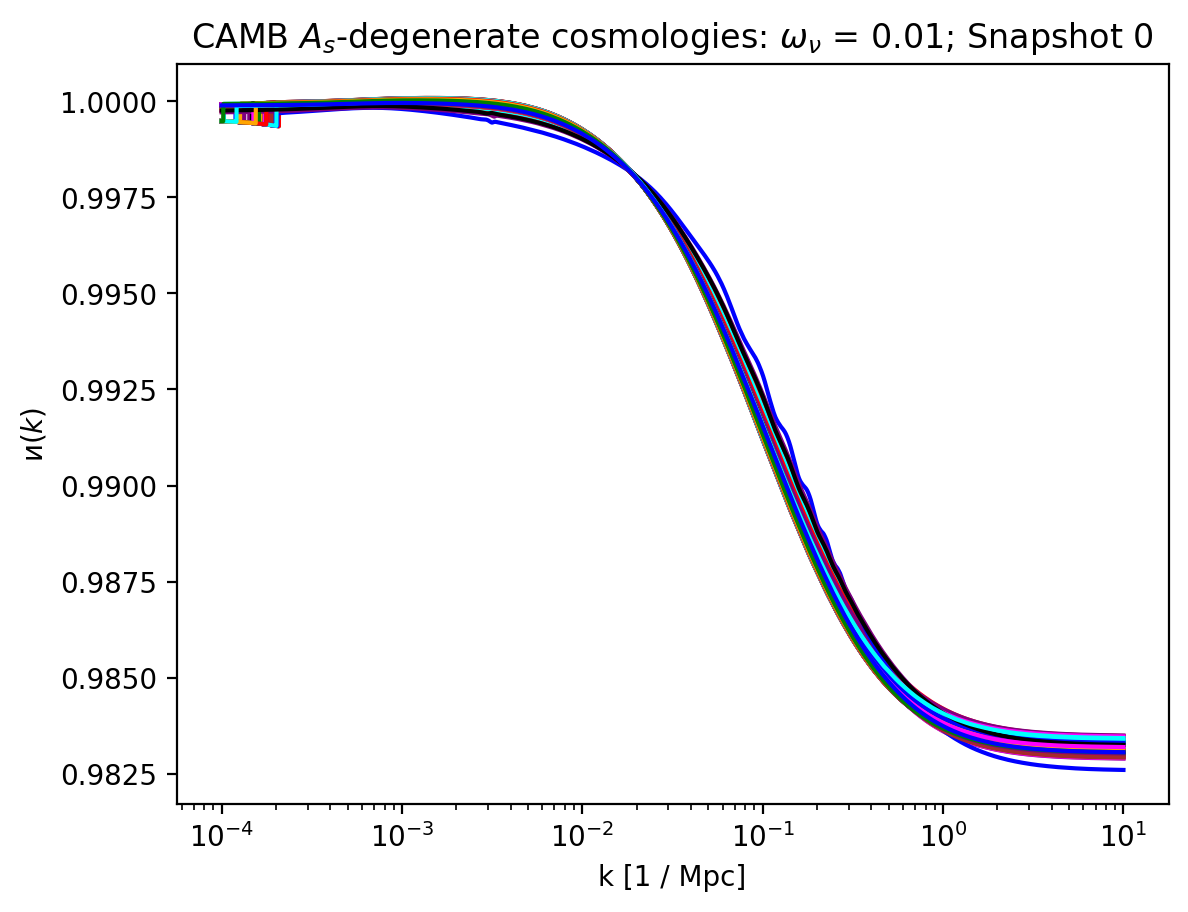

In [14]:
fig, axs = plt.subplots()
ks, rats = ci.model_ratios(snap_index, spec_sims[onh2], axs,
    massive='x', skips=[], omnuh2_str=onh2_str, models=random_cosm,
    suppress_legend=True, title="CAMB $A_s$-degenerate cosmologies");
plt.savefig("degenerate_asymptotes.png")

In [15]:
true_asymptotes = []

for model_i in range(len(rats)):
    tail_start_idx = len(rats[model_i]) - asymptote_sample_size
    tail = rats[model_i][tail_start_idx:len(rats[model_i])]
    true_asymptotes.append(np.average(tail))

true_asymptotes = np.array(true_asymptotes)

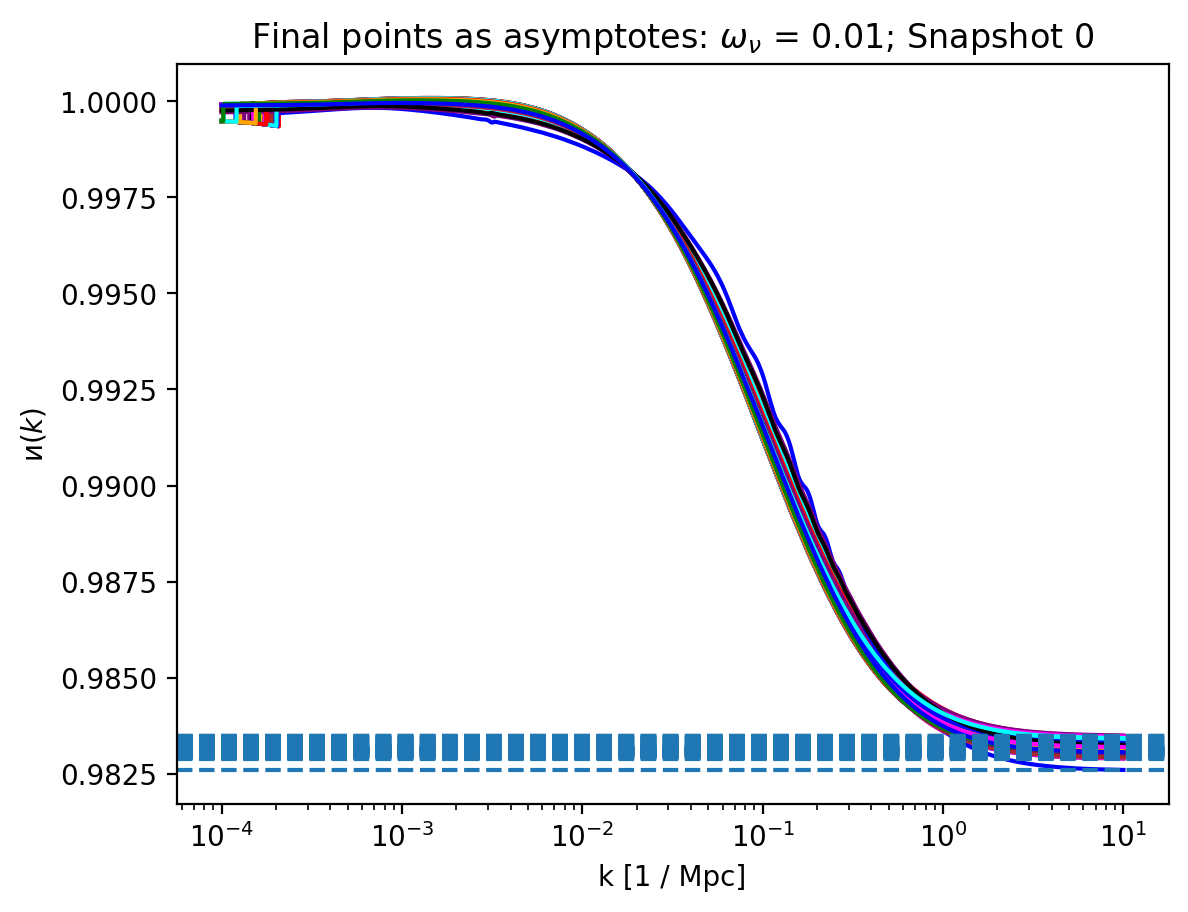

In [16]:
fig, axs = plt.subplots()
ci.model_ratios(snap_index, spec_sims[onh2], axs,
    massive='x', skips=[], omnuh2_str=onh2_str,
    title="Final points as asymptotes", models=random_cosm, suppress_legend=True)
for asymptote in true_asymptotes:
    axs.axhline(asymptote, linestyle='--')

C:\Users\Lukas\Anaconda3\envs\ay160\lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


y-intercept for this fit is 0.49157207045823637
slope for this fit is -2.213843793341456e+17
Reduced chi squared value for this fit: 2.514418716547181e-08


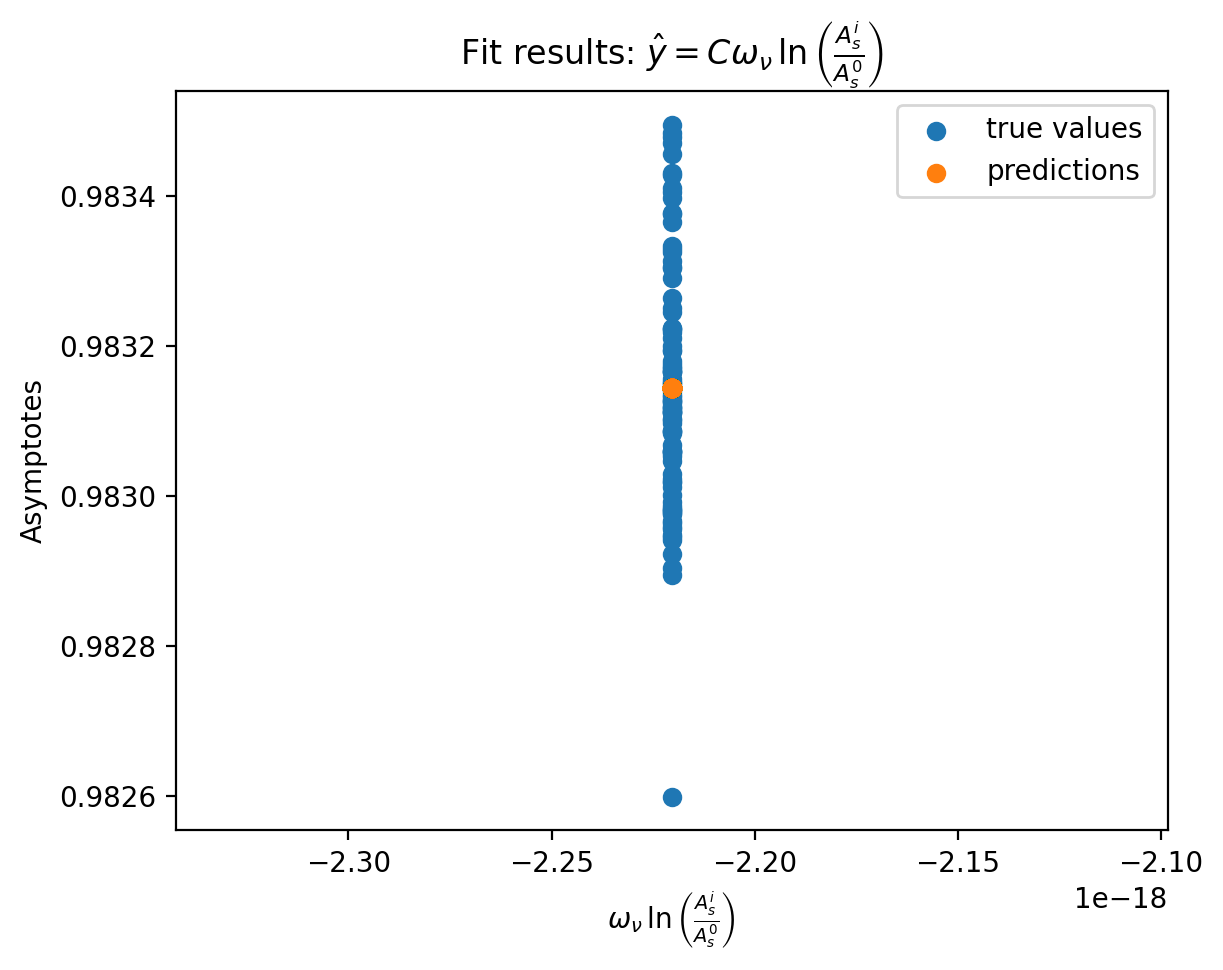

In [17]:
from numpy.polynomial.polynomial import polyfit
A_s = [random_cosm.loc[i]["A_s"] for i in range(1 + num_degenerate)]
x6 = onh2 * np.log(A_s[1:] / A_s[0])

model_desc_6 = r"\omega_\nu \, \ln \left( \frac{A_s^i}{A_s^0} \right)$"

plt.scatter(x6, true_asymptotes, label="true values")

b6, m6 = polyfit(x6, true_asymptotes, 1)

pred6 = m6 * x6 + b6
plt.scatter(x6, pred6, label="predictions")

print("y-intercept for this fit is", b6)
print("slope for this fit is", m6)

plt.ylabel("Asymptotes")
plt.xlabel("$" + model_desc_6)
plt.title(r"Fit results: $\hat{y} = C" + model_desc_6)
plt.legend()

chis6 = (true_asymptotes - pred6) ** 2 / pred6
red_chisq6 = sum(chis6) / len(x6)
print("Reduced chi squared value for this fit:", red_chisq6)

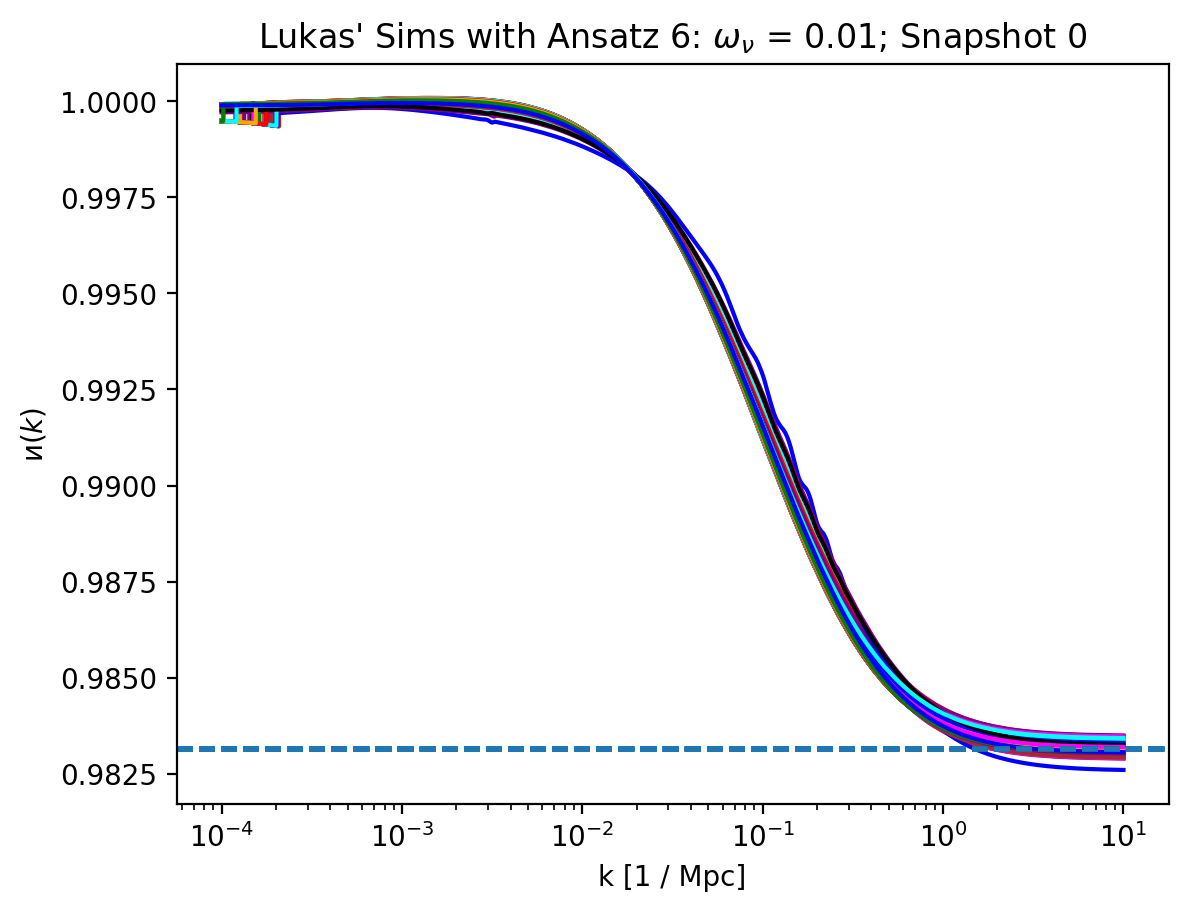

In [18]:
fig, axs = plt.subplots()
ci.model_ratios(snap_index, spec_sims[onh2], axs,
    massive='x', omnuh2_str=onh2_str, models=random_cosm,
    title="Lukas' Sims with Ansatz 6", suppress_legend=True)

for i in range(len(true_asymptotes)):
    axs.axhline(m6 * x6[i] + b6, linestyle='--')

The estimates are pretty obviously misaligned in several cases, but that's okay,
because we're deliberately running this experiment at the worst omega_nu value
on the range: 0.01.

However, one thing I can't explain: why do the randomly-generated cosmologies
tend to cluster toward the higher side of this plot? The Aletheia set doesn't
have such a dramatic lopsidedness (see the notebook divergence_asymptotes), but
maybe the cosmologies were carefully selected to that end?

Unfortunately, chi-squared is not meaningful anymore because there is no
longer a common theme to the models (before, one could say that they were all
Aletheia cosmologies). All we can do is procure a maximum error term across
all randomly-generated cosmologies.

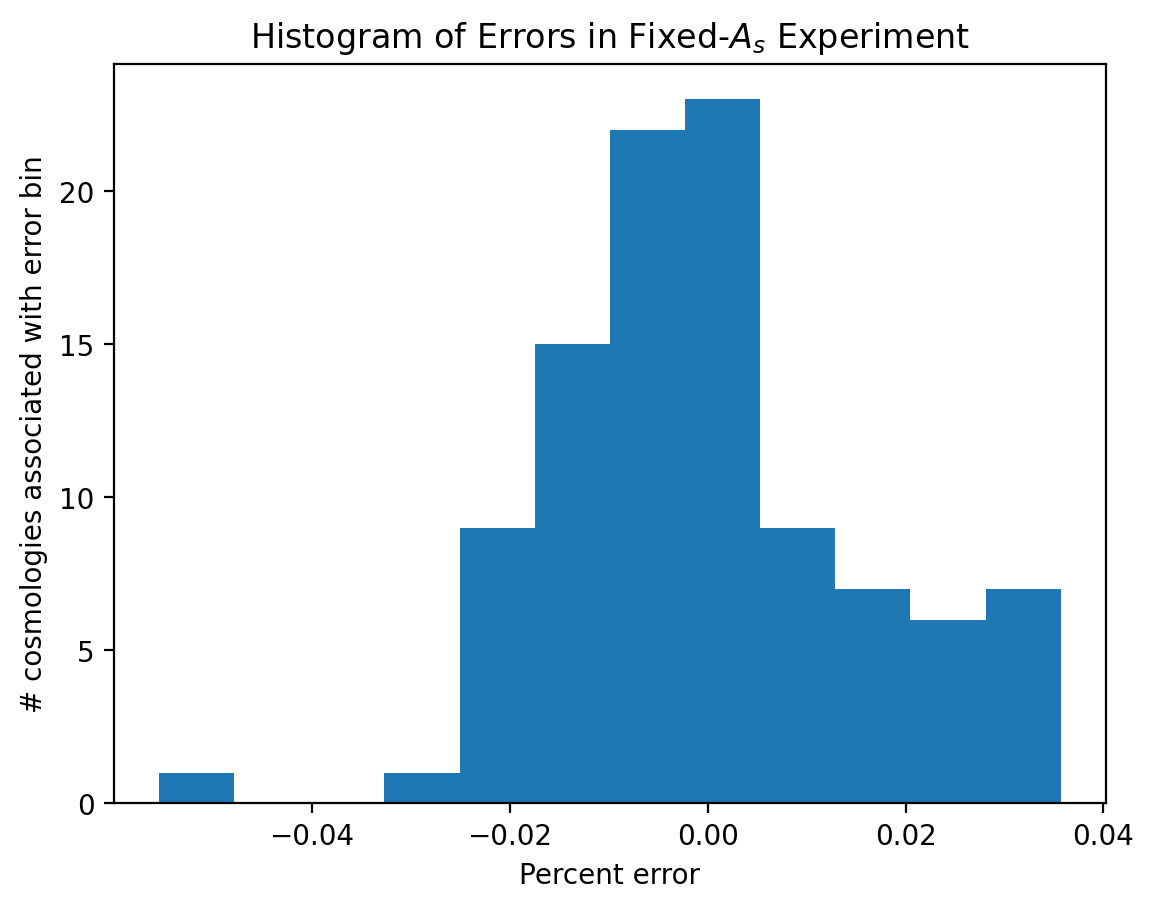

In [24]:
percent_error = (true_asymptotes - pred6) / true_asymptotes * 100
plt.hist(percent_error, bins=12)
plt.title("Histogram of Errors in Fixed-$A_s$ Experiment")
plt.ylabel("# cosmologies associated with error bin")
plt.xlabel("Percent error")
plt.savefig("degenerate_histogram.png")

In [20]:
print(max(percent_error))
print(min(percent_error))

0.035681007457481186
-0.055437824250399975


In [21]:
np.where([percent_error == max(percent_error)])

(array([0], dtype=int64), array([59], dtype=int64))

In [22]:
percent_error[60]

-0.012706538167475025

In [23]:
random_cosm.iloc[31]

Name           Columbus_0
ombh2            0.022445
omch2            0.120567
n_s                  0.96
A_s                   0.0
OmB                  0.05
OmC              0.268584
OmM              0.318584
OmK              0.063373
OmL              0.681416
h                0.600314
w0               -0.96623
wa               0.001359
EOmDE                   -
z(4)                  2.0
z(3)                  1.0
z(2)                 0.57
z(1)                  0.3
z(0)                  0.0
Lbox               1000.0
sigma8            0.82755
omnuh2               0.01
mnu              0.930425
nnu_massive             1
Name: 31, dtype: object